In [20]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

import keras # broken for keras >= 2.0, use 1.2.2
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape

from utils import load_weights, Box, yolo_net_out_to_car_boxes, draw_box

In [21]:
keras.__version__

'2.1.4'

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3787270420257311800
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10487001908
locality {
  bus_id: 1
}
incarnation: 11536883402928217436
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


In [3]:
keras.backend.set_image_dim_ordering('th')

In [4]:
model = Sequential()
model.add(Convolution2D(16, 3, 3,input_shape=(3,448,448),border_mode='same',subsample=(1,1)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(64,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(128,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(256,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(512,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Flatten())
model.add(Dense(256))
model.add(Dense(4096))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(1470))

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 448, 448)      448       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 448, 448)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 224, 224)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 224, 224)      4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 224, 224)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 112, 112)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 112, 112)      18496     
__________

In [6]:
load_weights(model,'./yolo-tiny.weights')

In [7]:
model.layers[0].get_weights()

[array([[[[ 3.55195075e-01, -3.73156697e-01, -3.67846251e-01,
            5.90099394e-01, -1.01551011e-01, -5.35987854e-01,
            5.09713352e-01,  2.70668328e-01, -3.41590106e-01,
            3.73181671e-01, -3.86301607e-01, -3.98071080e-01,
            6.31922007e-01, -9.58716497e-02, -5.81265628e-01,
            5.29340804e-01],
          [ 2.81358302e-01, -3.76596034e-01,  2.91880280e-01,
           -3.13448668e-01, -2.88940668e-01,  4.98001009e-01,
           -7.00900406e-02, -4.52656209e-01,  4.01368022e-01,
            2.36727834e-01, -3.11860681e-01, -2.27922022e-01,
           -3.29123229e-01, -3.05911601e-01, -3.08207572e-01,
           -4.37544525e-01],
          [-3.69774431e-01, -3.30627292e-01, -4.30169523e-01,
           -3.40497851e-01,  3.26436549e-01,  2.96305001e-01,
            2.85569102e-01,  3.09428215e-01,  2.52764404e-01,
            2.76269257e-01,  2.53304034e-01,  2.21325412e-01,
            2.64275819e-01,  1.17305465e-01,  1.53303400e-01,
            

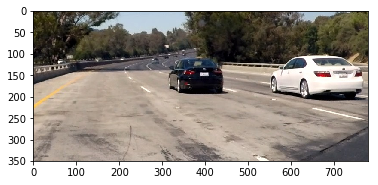

In [8]:
imagePath = './test_images/test1.jpg'
image = plt.imread(imagePath)
image_crop = image[300:650,500:,:]
resized = cv2.resize(image_crop,(448,448))
plt.imshow(image_crop)

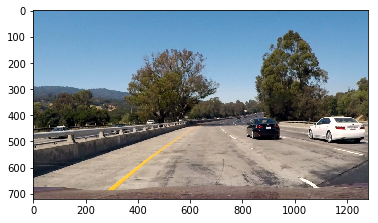

In [9]:
plt.imshow(image)

In [10]:
batch = np.transpose(resized,(2,0,1))
batch = 2*(batch/255.) - 1
batch = np.expand_dims(batch, axis=0)
out = model.predict(batch)
print(out)

[[0.07306324 0.022391   0.04073807 ... 0.55529416 0.29223418 0.44075093]]


In [11]:
print(len(out[0]))

1470


In [12]:
boxes = yolo_net_out_to_car_boxes(out[0], threshold = 0.0045)

In [13]:
print(len(boxes))

2


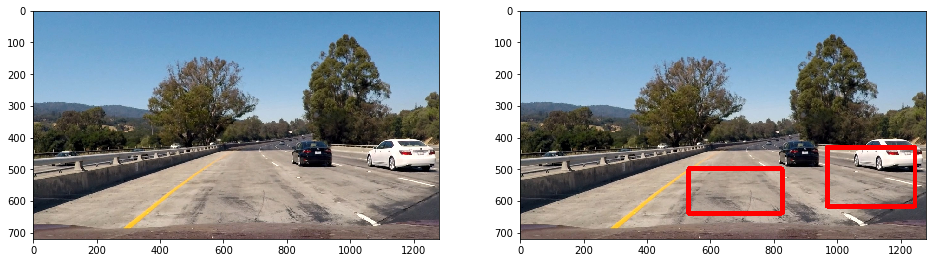

In [14]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
ax1.imshow(image)
ax2.imshow(draw_box(boxes,plt.imread(imagePath),[[500,1280],[300,650]]))

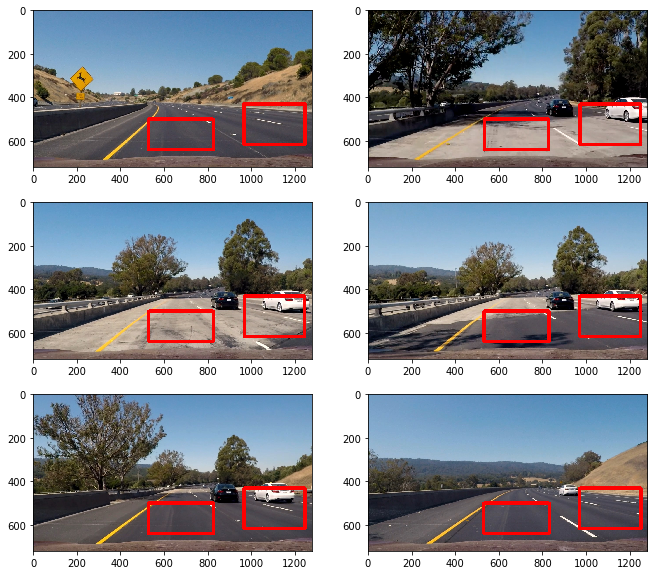

In [15]:
images = [plt.imread(file) for file in glob.glob('./test_images/*.jpg')]
batch = np.array([np.transpose(cv2.resize(image[300:650,500:,:],(448,448)),(2,0,1)) 
                  for image in images])
batch = 2*(batch/255.) - 1
out = model.predict(batch)
f,((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(11,10))
for i,ax in zip(range(len(batch)),[ax1,ax2,ax3,ax4,ax5,ax6]):
    boxes = yolo_net_out_to_car_boxes(out[i], threshold = 0.0045)
    ax.imshow(draw_box(boxes,images[i],[[500,1280],[300,650]]))

In [16]:
def frame_func(image):
    crop = image[300:650,500:,:]
    resized = cv2.resize(crop,(448,448))
    batch = np.array([resized[:,:,0],resized[:,:,1],resized[:,:,2]])
    batch = 2*(batch/255.) - 1
    batch = np.expand_dims(batch, axis=0)
    out = model.predict(batch)
    boxes = yolo_net_out_to_car_boxes(out[0], threshold = 0.0045)
    return draw_box(boxes,image,[[500,1280],[300,650]])

In [17]:
project_video_output = './project_video_output.mp4'
clip1 = VideoFileClip("./project_video.mp4")

In [18]:
lane_clip = clip1.fl_image(frame_func) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


100%|█████████▉| 1260/1261 [00:23<00:00, 53.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

CPU times: user 17.2 s, sys: 2.51 s, total: 19.7 s
Wall time: 23.8 s


In [19]:
%%HTML
<video width="320" height="240" controls>
  <source src="./project_video_output.mp4 
" type="video/mp4">
</video>